# SIGLE: Selective Inference in Generalized Linear models through conditional MLE
# The case of the Sparse Logistic Regression


### Authors: Quentin Duchemin & Yohann De Castro

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from inverse_map import inverse_map, train_network
import torch
import scipy
import scipy as sc
import scipy.stats
from PSIGLL import *

In [3]:
from ipyparallel import Client

c = Client()
print(c.ids)
dview = c[:]
import numpy as np

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


# I) SEI-SLR

In [33]:
n,p = 11,10
X = np.random.normal(0,1,(n,p))
X /= np.tile(np.linalg.norm(X,axis=0),(n,1))
theta = np.zeros(p)
theta[:2] = [1,1]
def logtemp(x):
    return (0.4/np.log(x))
nb_expe = 1

settings= [{'n':n,
            'p':p,
            'X':X,
            'theta':theta,
            'cross_val':False,
            'lamb':0.6,
            'temperature':logtemp, 
            'nb_expe':nb_expe, 
            'file':'test/'}]

SEI_SLR(settings=10*settings, conditioning_signs=False, total_length_SEISLR_path=1500,compute_pvalues=False)

In [2]:
path = 'test/'

# Finding all the saved experiments
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
indexes = []
for file in onlyfiles:
    if file[:6]=='last_y':
        indexes.append(file[6:-4])
print('Total of number of simulated annealing:', len(indexes))

Total of number of simulated annealing: 10


### 1) Visualization of results

In [35]:
index = indexes[1]

M = np.load(path+index+'M.npy')
X = np.load(path+index+'X.npy')
lamb = np.load(path+index+'lamb.npy')[0]
theta_obs = np.load(path+index+'theta_obs.npy')
sig = np.load(path+index+'sig.npy')
yobs = np.load(path+index+'yobs.npy')
if n<=17:
    bnM_admi, ls_states_admissibles = compute_selection_event(theta_obs,X,yobs,lamb,conditioning_signs=False)
else:
    ls_states_admissibles = SEI_by_sampling(sig, X, lamb, M)

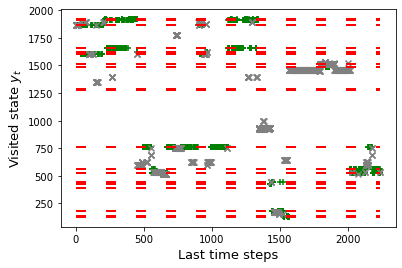

In [36]:
last_visited_states(indexes,path,ls_states_admissibles)

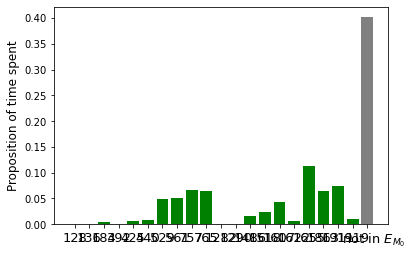

In [37]:
histo_time_in_selection_event(indexes, path, ls_states_admissibles)

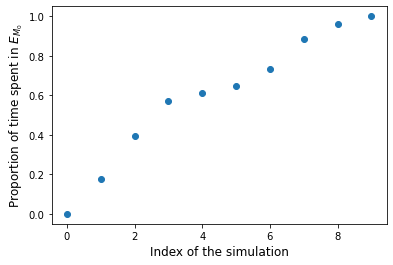

In [38]:
time_in_selection_event(indexes, path, ls_states_admissibles)

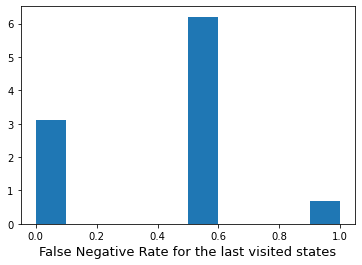

In [39]:
ls_FNR = np.load('test/FNR'+index+'.npy')
hist = plt.hist(ls_FNR,density=True)
plt.ylabel('')
plt.xlabel('False Negative Rate for the last visited states', fontsize=13)
plt.show()

# I) CDF of P-values

##### Data

In [90]:
n,p = 100,10
lamb = 0.4

d = 2
theta = 3*np.ones(d)
truetheta = np.zeros(p)
truetheta[:d] = theta

np.random.seed(1)
X = np.random.normal(0,1,(n,p))
X /= np.tile(np.linalg.norm(X,axis=0),(n,1))
matXtrue = X[:,:d]

sig = sigmoid(matXtrue @ theta)
yobs = np.random.rand(n) <= sig
model = LogisticRegression(C = 1/lamb, penalty='l1', solver='liblinear', fit_intercept=False)
model.fit(X, yobs)
theta_obs = model.coef_[0]
M = np.where( np.abs(theta_obs) > 1e-5)[0]
print('Selected support: ', M)

Selected support:  [0 1 4 7 8]


### <span style="color:red">SEI by sampling ?</span>
Set *SEI_by_sampling* to *True* in order to approximate the selection event by sampling. Otherwise, the full state space will be visited to compute exactly the selection event. 

If $n\geq17$, *SEI_by_sampling* should be set to *True* for computational issue.

In [ ]:
SEI_sampling = True
if SEI_sampling:
    states = SEI_by_sampling(sig, X, lamb, M)

##### Compute the conditional distribution of the observations

In [92]:
if SEI_sampling:
    probasalt, states = true_conditional_distribution(theta_obs,X,yobs,lamb,truetheta,conditioning_signs=False,states=states)
else:
    probasalt, states = true_conditional_distribution(theta_obs,X,yobs,lamb,truetheta,conditioning_signs=False)
probasnull, states = true_conditional_distribution(theta_obs,X,yobs,lamb,np.zeros(X.shape[1]),conditioning_signs=False,states=states)
print('Number of states in the selection event: ', len(states))

Number of states in the selection event:  260


##### Computing $\bar \pi ^{\pi ^0}$ and training the NN aiming at computing $\Psi=\Xi^{-1}$

In [93]:
idxs_null = np.random.choice([i for i in range(len(states))], size=300)
lsy = []
for i in idxs_null:
    lsy.append(np.array(states[i]))
n,p = np.shape(X)
bern = 0.5 * np.ones(n)
matXtrue = X[:,M]
tildeGN_12, barpi = params_saturated(bern, matXtrue, lsy)
net, loss_values = train_network(matXtrue,max(3,truetheta[0]),nb_epochs=1000)

##### P-values from the weak learner

In [94]:
lspvals_naive = pval_weak_learner(probasalt,probasnull,states,barpi)

##### P-values from SIGLE

In [98]:
lspvals_selec, lspvals_sat = pval_SIGLE(states, probasalt, X, M, barpi, net, use_net_MLE=True, l2_regularization=5)

##### P-values from Taylor & Tibshirani '18

In [96]:
lspvals_tay = pval_taylor(probasalt,states,X,lamb,M,show_distributions=False)

##### RESULTS

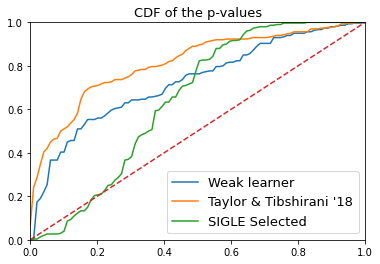

In [99]:
lists_pvalues = [lspvals_naive, lspvals_tay, lspvals_selec]
names = ['Weak learner', "Taylor & Tibshirani '18", 'SIGLE Selected']
plot_cdf_pvalues(lists_pvalues, names, name_figsave=None)